In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

In [7]:
train_imgs_path = "../input/3dircadb/3DIRCADB/train/Images/"
train_masks_path = "../input/3dircadb/3DIRCADB/train/Masks"
test_imgs_path = "../input/3dircadb/3DIRCADB/test/Images"
test_masks_path = "../input/3dircadb/3DIRCADB/test/Masks"

(512, 512, 3) 0 255


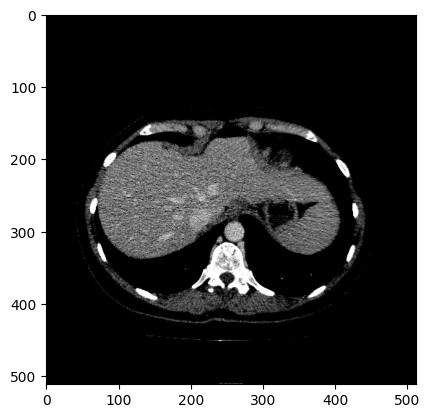

In [8]:
img = cv2.imread("../input/3dircadb/3DIRCADB/train/Images/images/image_100.png")
plt.imshow(img)
print(img.shape, np.amin(img), np.amax(img))

(512, 512, 3) 0 255


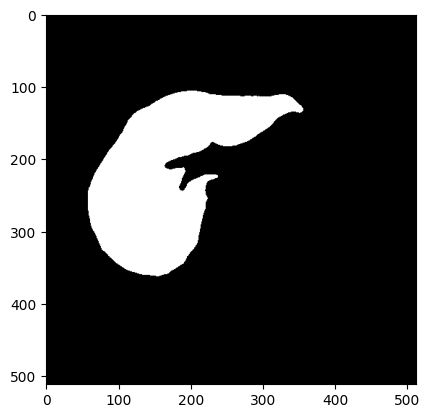

In [9]:
img = cv2.imread("../input/3dircadb/3DIRCADB/test/Masks/masks/mask_100.png")
plt.imshow(img)
print(img.shape, np.amin(img), np.amax(img))

In [10]:
from tensorflow.keras.models import *
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
model = unet()

In [12]:
model.save('lits_unet.h5')

In [13]:
# Save the model to the Kaggle output directory
model.save('/kaggle/working/lits_unet.h5')

In [14]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)
def trainGenerator(batch_size,train_path,image_folder,
                   mask_folder,
                   aug_dict,
                   image_color_mode = "grayscale",
                   mask_color_mode = "grayscale",
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   flag_multi_class = False,
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (256,256),
                   seed = 1,
                   subset = 'training'):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        subset = subset)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        subset = subset)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [15]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    validation_split=0.2)
train_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))
valid_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,subset = 'validation',
                                target_size = (512,512))


In [16]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [17]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

Found 1647 images belonging to 1 classes.
Found 1647 images belonging to 1 classes.


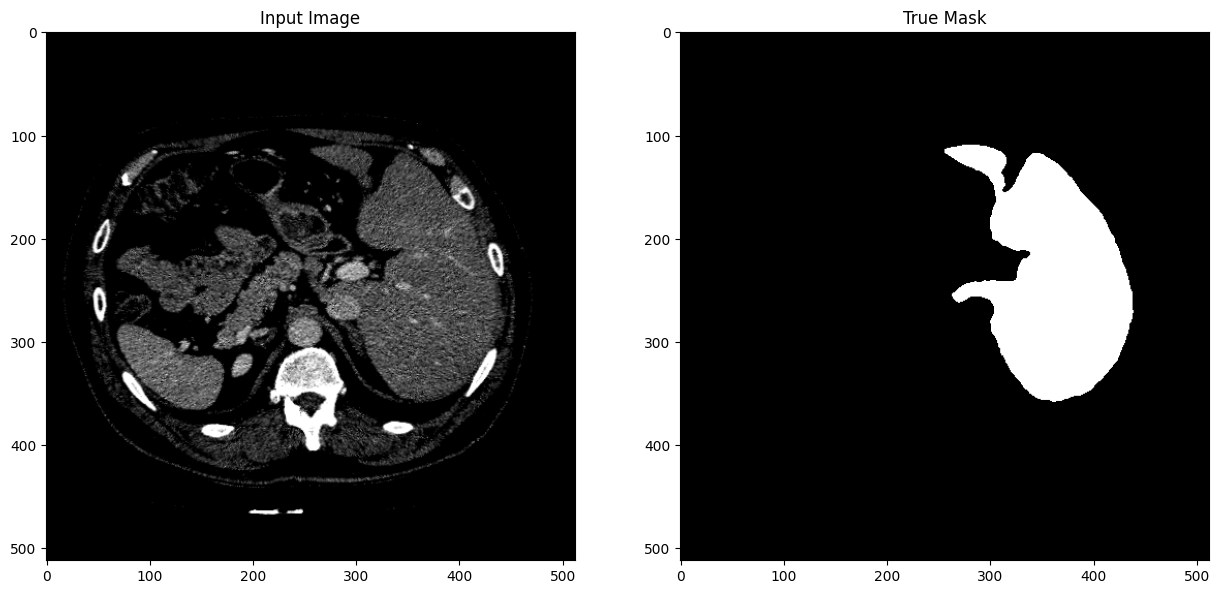

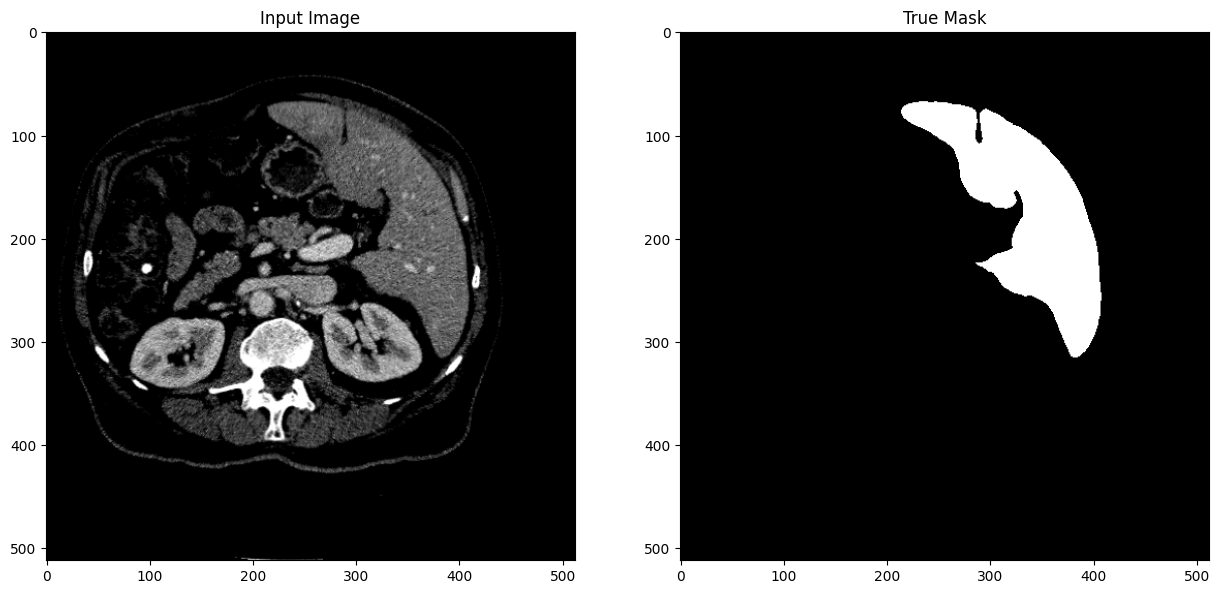

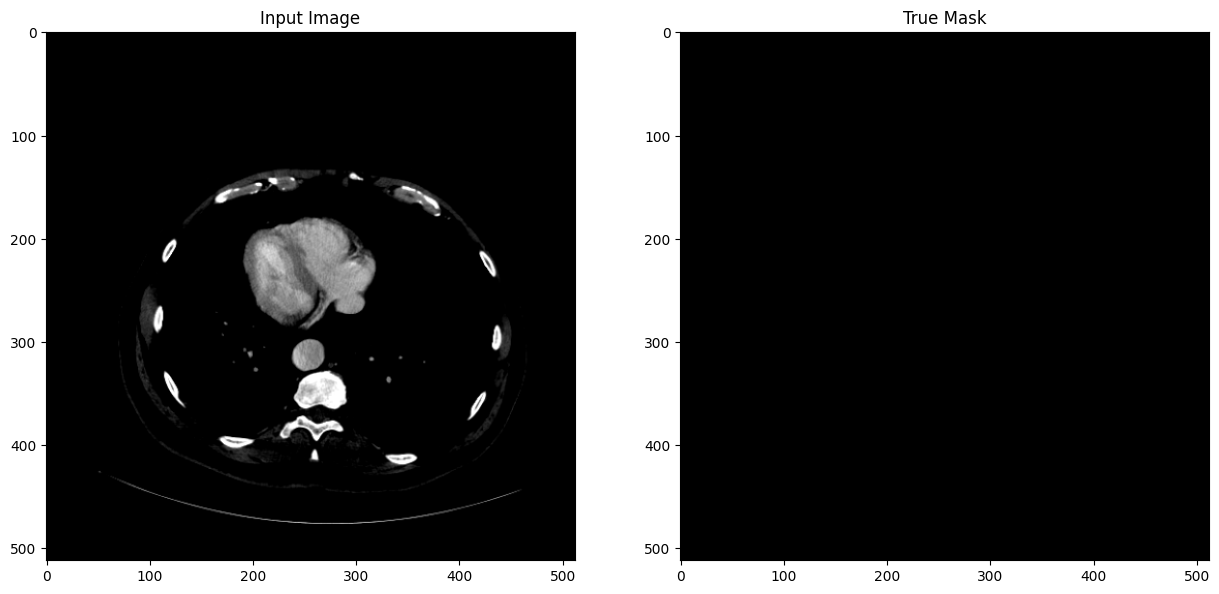

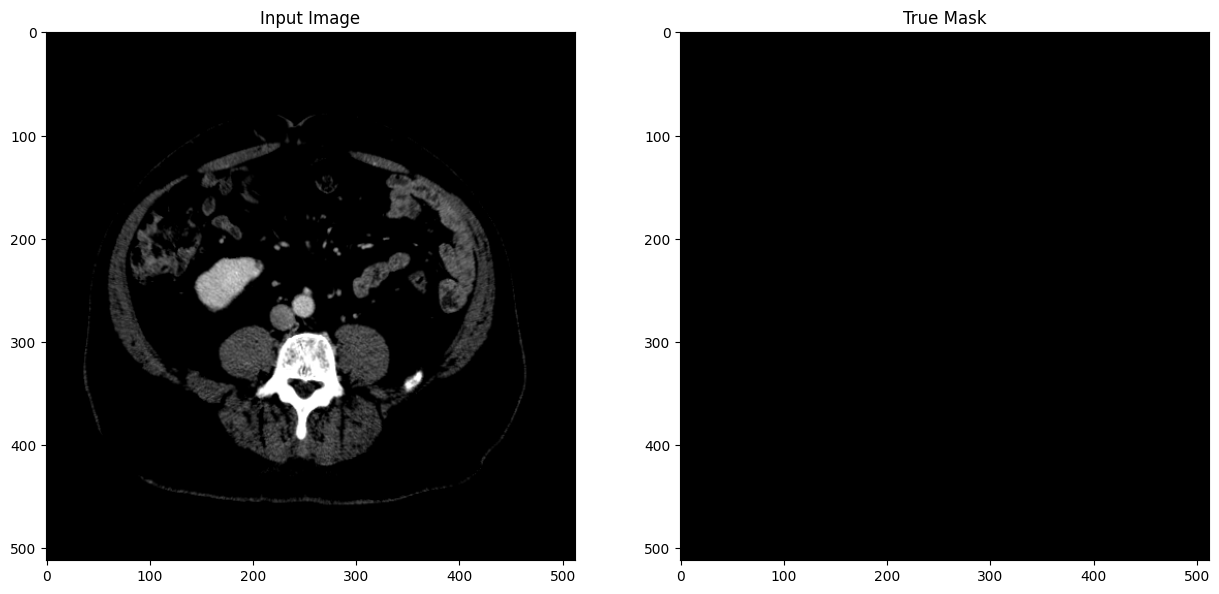

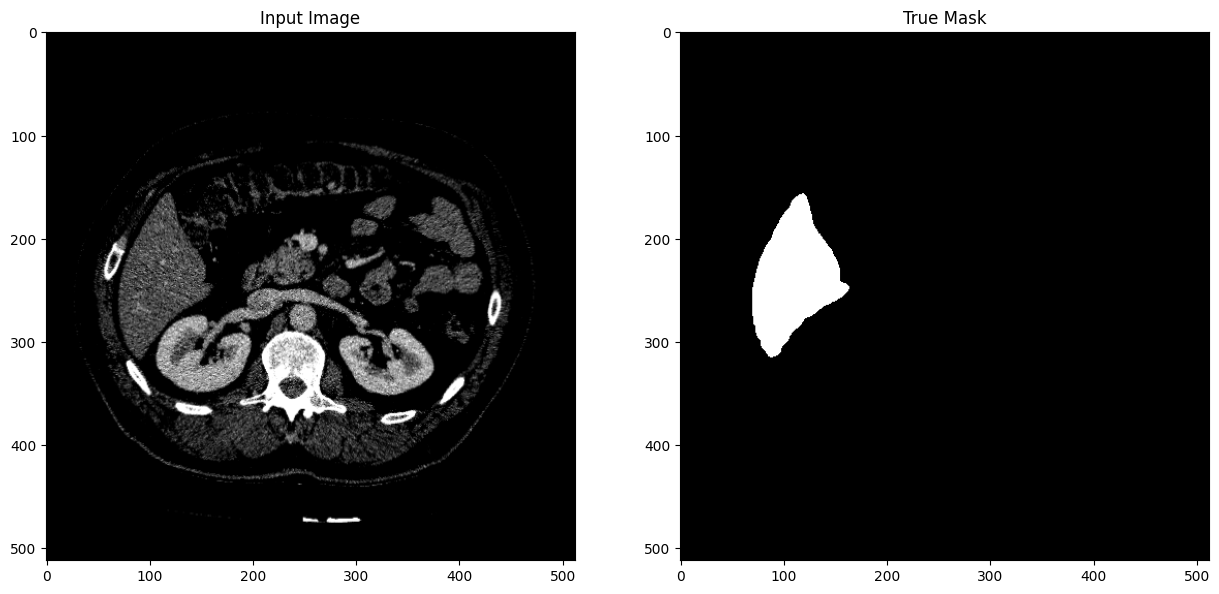

In [18]:
show_dataset(train_generator, 5)

Found 411 images belonging to 1 classes.
Found 411 images belonging to 1 classes.


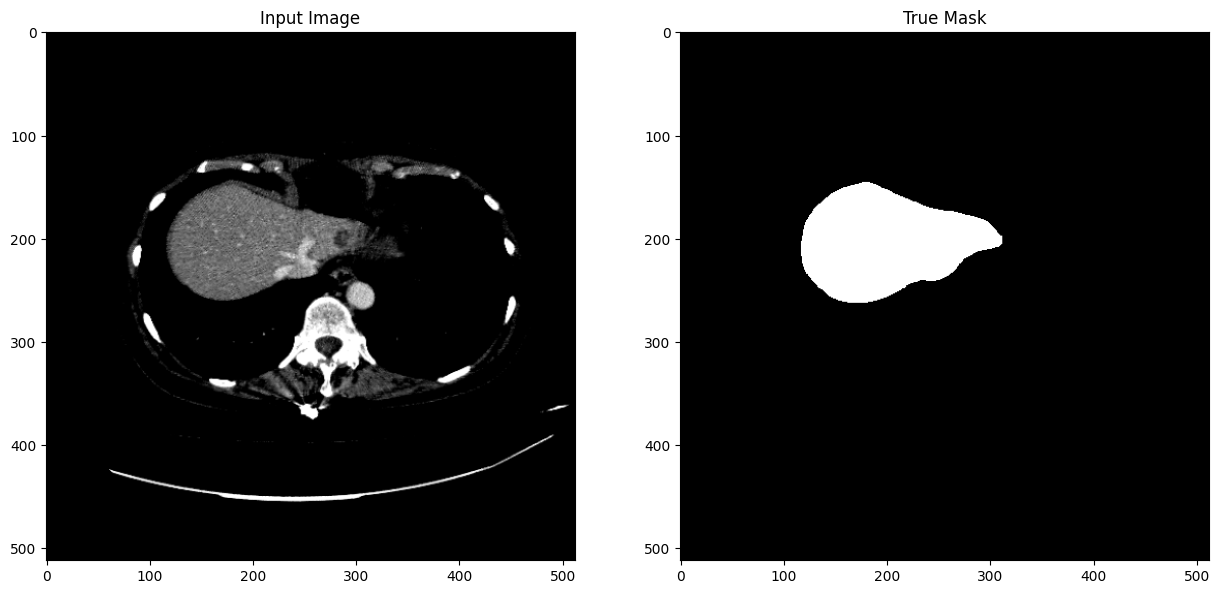

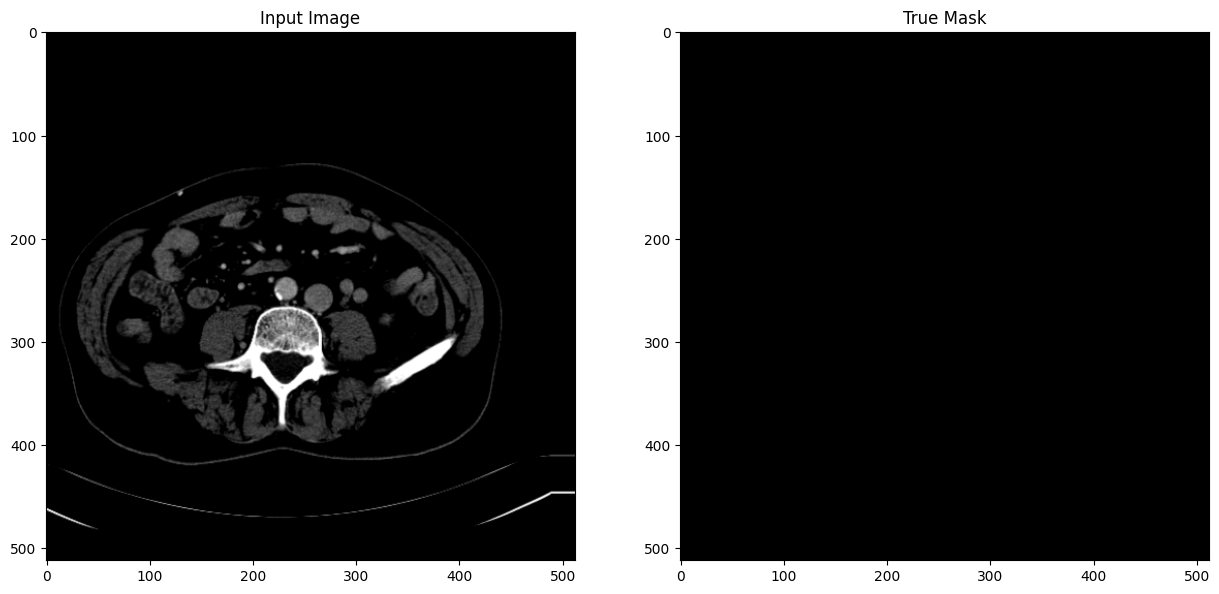

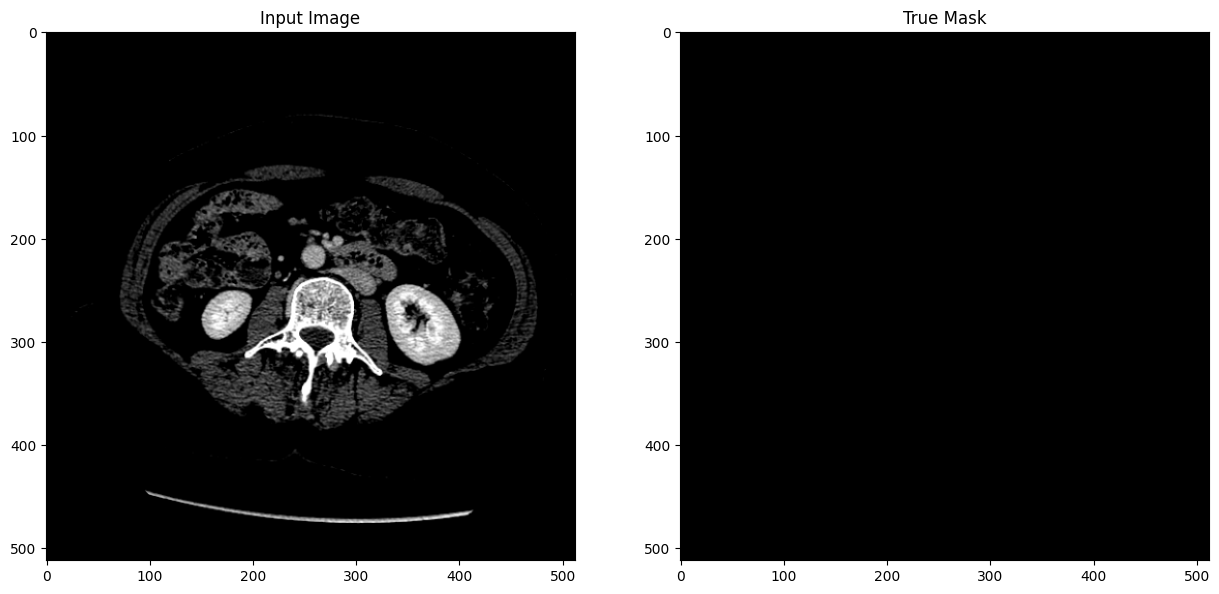

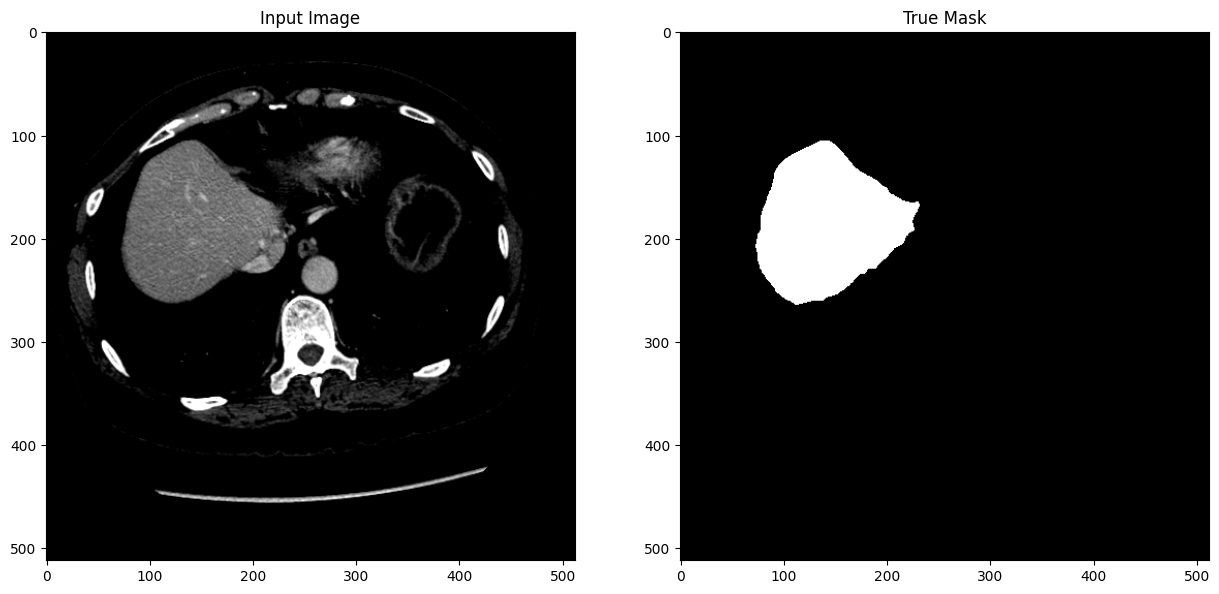

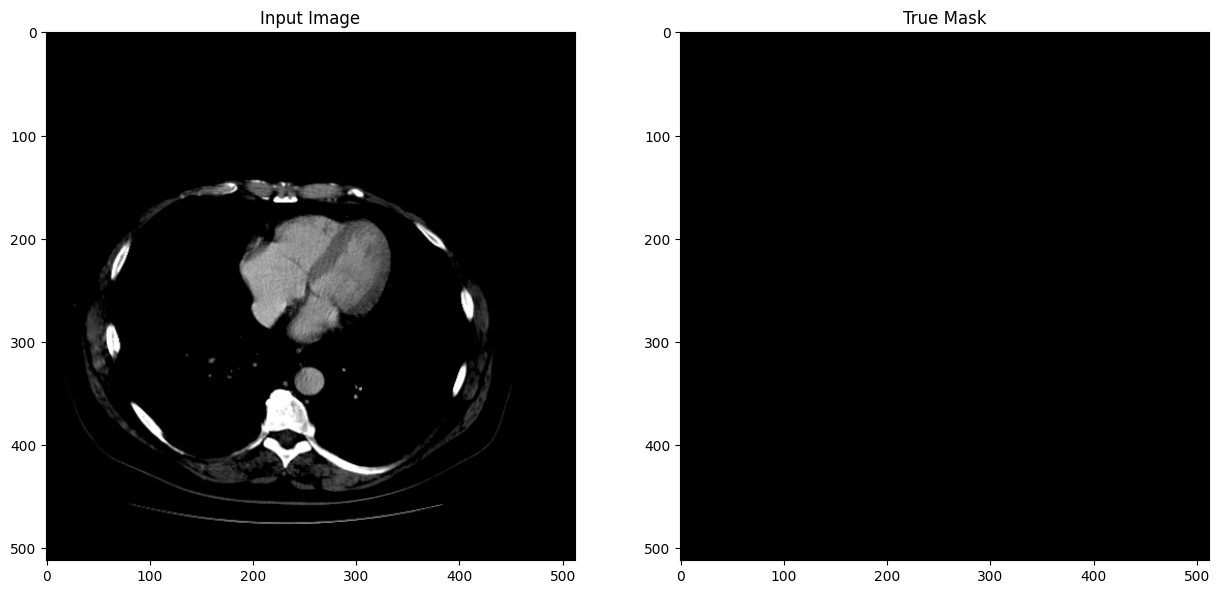

In [19]:
show_dataset(valid_generator, 5)

In [20]:
model = unet(input_size=(512,512,1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 512, 512,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │    524,544 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
# model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path = "{}_weights.best.weights.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [23]:
num_train = 1647
num_valid = 411
train_batchsize = 16
valid_batchsize = 16
Step_train = num_train // train_batchsize
Step_valid = num_valid // valid_batchsize
epochs = 10

In [24]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=Step_train,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=Step_valid,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/10


2024-04-25 16:28:54.231100: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,512,512]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-25 16:28:54.999790: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.768801083s
Trying algorithm eng0{} for conv (f32[16,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,512,512]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

 97/102 ━━━━━━━━━━━━━━━━━━━━ 4s 965ms/step - accuracy: 0.9193 - loss: 0.4087

2024-04-25 16:34:04.257549: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[15,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,512,512]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-25 16:34:04.946945: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.689573022s
Trying algorithm eng0{} for conv (f32[15,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,512,512]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9208 - loss: 0.3991

2024-04-25 16:37:35.439395: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[11,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,64,512,512]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-25 16:37:35.670095: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.230814963s
Trying algorithm eng0{} for conv (f32[11,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,64,512,512]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2


Epoch 1: val_loss improved from inf to 0.07036, saving model to cxr_reg_weights.best.weights.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 602s 4s/step - accuracy: 0.9211 - loss: 0.3972 - val_accuracy: 0.9663 - val_loss: 0.0704
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.9633 - loss: 0.0915
Epoch 2: val_loss improved from 0.07036 to 0.05743, saving model to cxr_reg_weights.best.weights.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9633 - loss: 0.0914 - val_accuracy: 0.9806 - val_loss: 0.0574
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.9666 - loss: 0.0812
Epoch 3: val_loss did not improve from 0.05743
102/102 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9667 - loss: 0.0810 - val_accuracy: 0.9771 - val_loss: 0.0730
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9641 - loss: 0.0893
Epoch 4: val_loss did not improve from 0.05743
102/102 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9641 - loss: 0.0890 - val_accuracy:

In [25]:
data_gen_args = dict(
                    fill_mode='nearest',
                    validation_split=0)
test_generator = trainGenerator(1,'/kaggle/input/3dircadb/3DIRCADB/test','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))

(512, 512, 1) (16, 512, 512, 1)


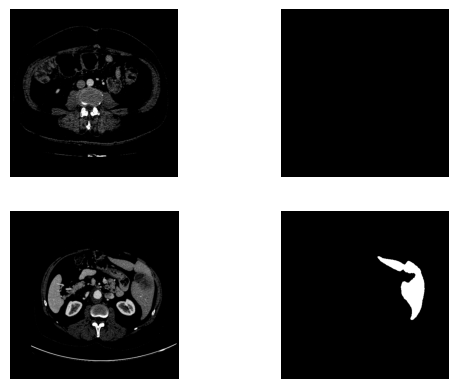

In [26]:
import matplotlib.pyplot as plt

# ... other parts of your code ...

gene = train_generator
for ct,mask in gene:
    print(ct[0].shape, mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    break
plt.show()

Found 765 images belonging to 1 classes.
Found 765 images belonging to 1 classes.


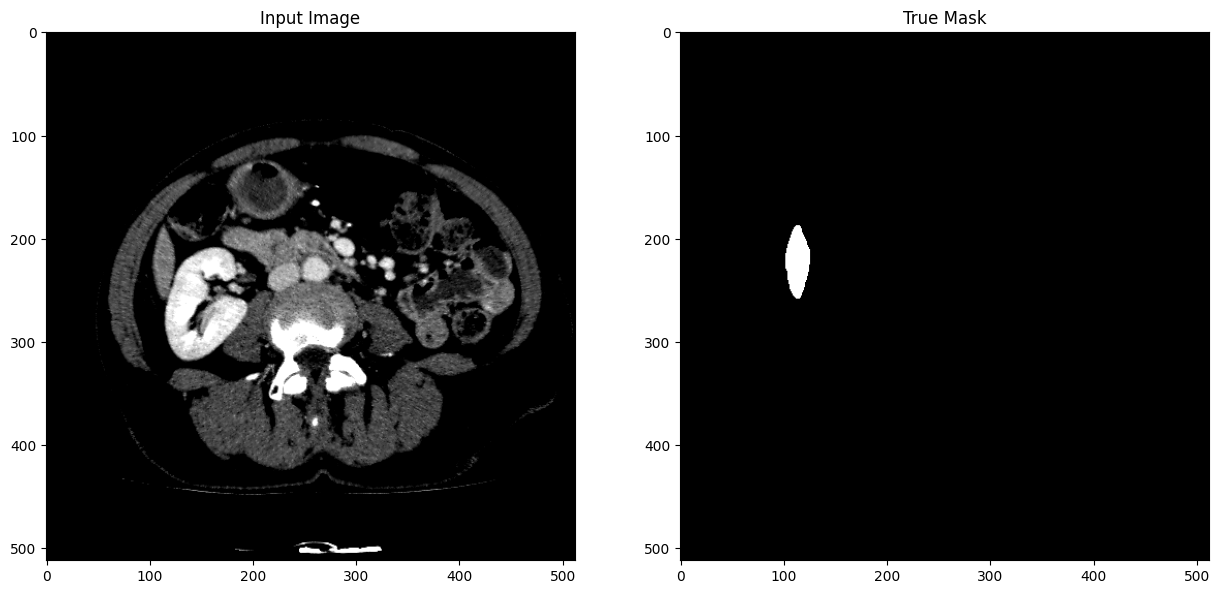

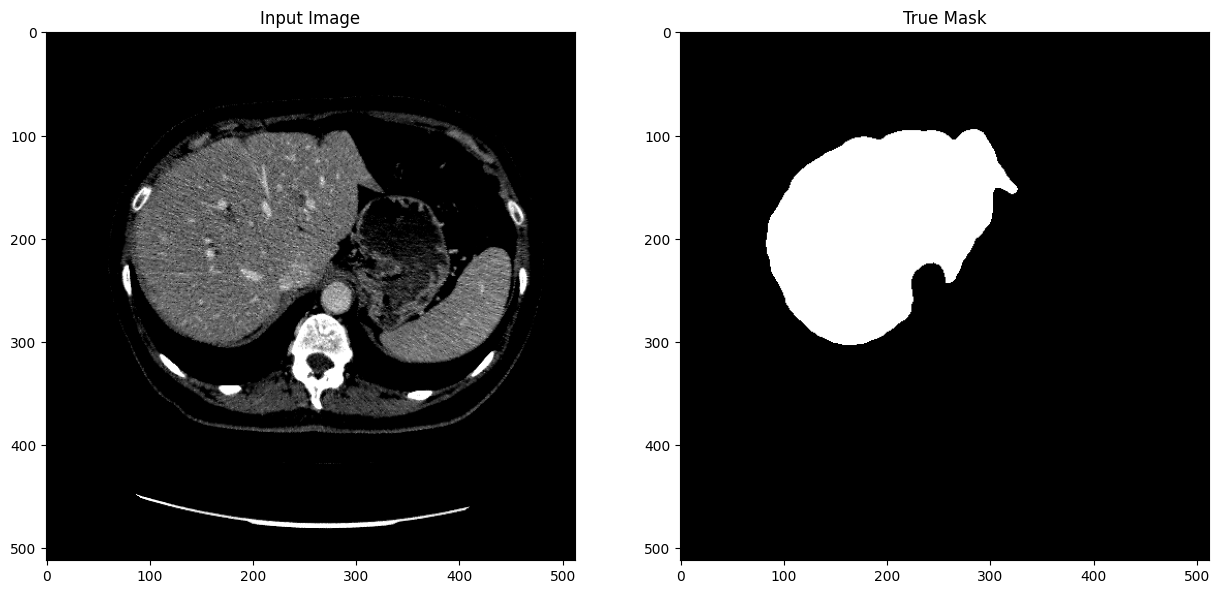

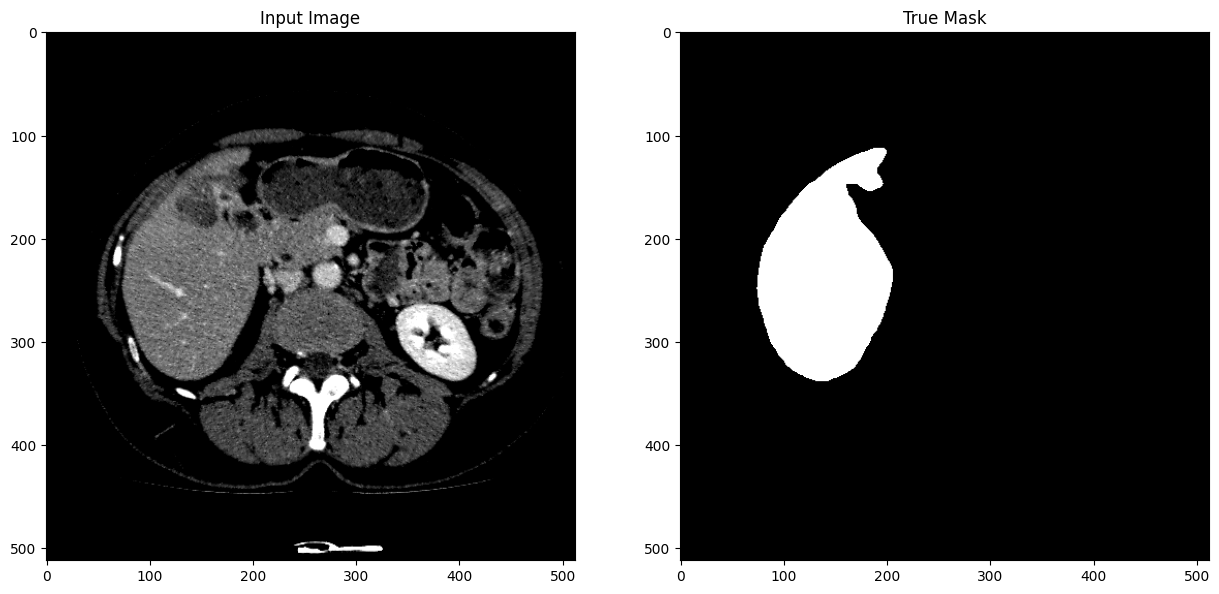

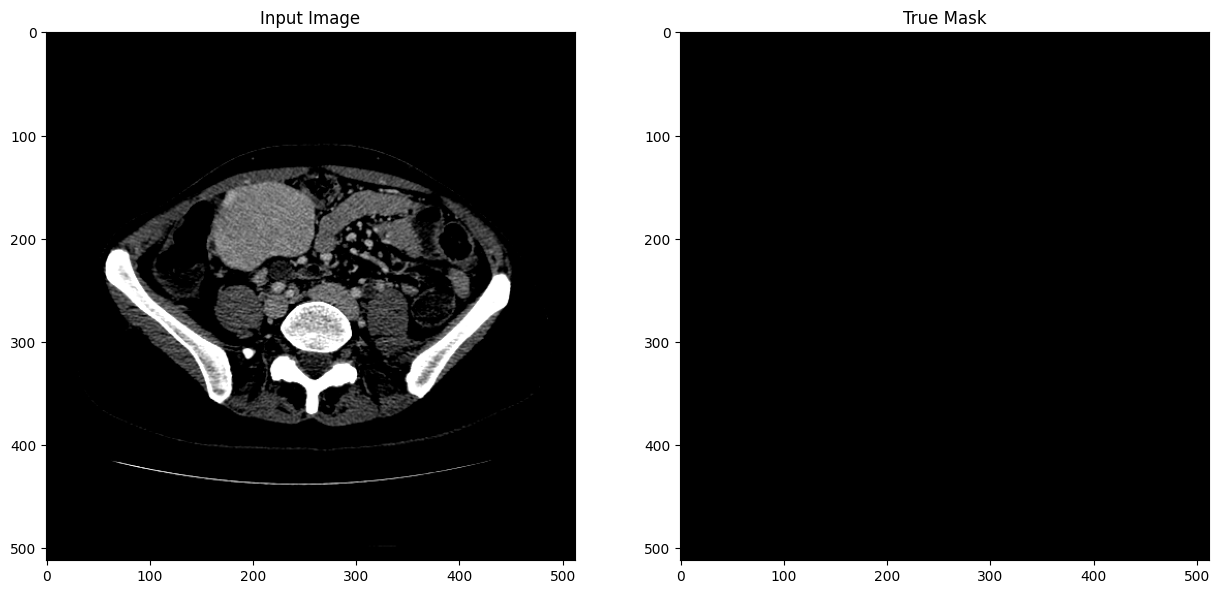

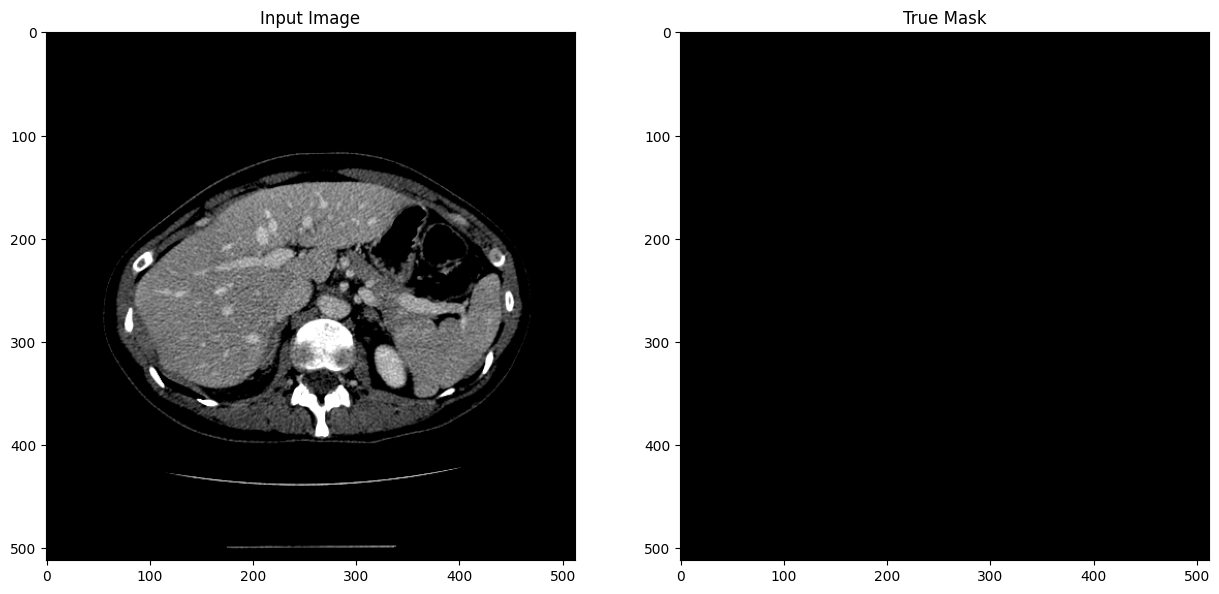

In [27]:
show_dataset(test_generator, 5)

In [28]:
results = model.predict(test_generator, steps=765, verbose=1)

765/765 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step


In [29]:
results.shape

(765, 512, 512, 1)

In [30]:
results[results >= 0.5] = 255
results[results < 0.5] = 0
results = np.asarray(results, np.uint8)

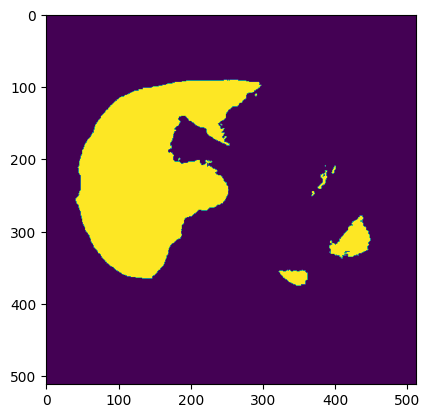

In [31]:
plt.imshow(results[5])

Segment each image one by one

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
predicted mask and true mask: 


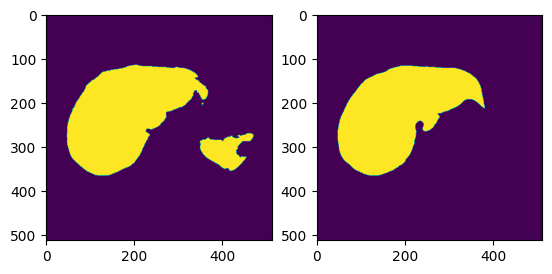

In [32]:
img = cv2.imread('/kaggle/input/3dircadb/3DIRCADB/test/Images/images/image_5.png')
img = img/255
image = img[:,:,0]
image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
image_tensor = tf.expand_dims(image_tensor, 0)
mask = model.predict(image_tensor)
mask[mask >= 0.5] = 255
mask[mask < 0.5] = 0
mask = np.asarray(mask, np.uint8)
print('predicted mask and true mask: ')
plt.subplot(1,2,1)
plt.imshow(mask[0])
plt.subplot(1,2,2)
true_mask = cv2.imread('/kaggle/input/3dircadb/3DIRCADB/test/Masks/masks/mask_5.png')
_true_mask = true_mask[:,:,0]
plt.imshow(_true_mask)

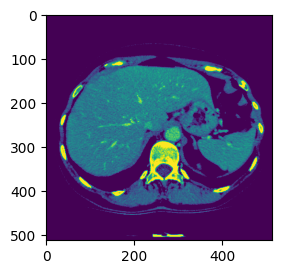

In [33]:
plt.subplot(1,2,1)
plt.imshow(image_tensor[0])

In [43]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/lits_unet.h5')


In [48]:
def validGenerator(batch_size, valid_path, image_folder, mask_folder, target_size=(256, 256)):
    image_datagen = ImageDataGenerator(rescale=1./255)
    mask_datagen = ImageDataGenerator(rescale=1./255)

    image_generator = image_datagen.flow_from_directory(
        valid_path,
        classes=[image_folder],
        class_mode=None,
        color_mode='grayscale',
        target_size=target_size,  # Resize images to the expected input size
        batch_size=batch_size,
        seed=1,
        shuffle=False
    )

    mask_generator = mask_datagen.flow_from_directory(
        valid_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode='grayscale',
        target_size=target_size,  # Resize masks to the expected input size
        batch_size=batch_size,
        seed=1,
        shuffle=False
    )

    valid_generator = zip(image_generator, mask_generator)
    for (img, mask) in valid_generator:
        yield (img, mask)

# Usage
valid_generator = validGenerator(16, '../input/3dircadb/3DIRCADB/test', 'Images', 'Masks', target_size=(256, 256))  # Use the expected input size of the model
predictions = model.predict(valid_generator, steps=Step_valid)


Found 765 images belonging to 1 classes.
Found 765 images belonging to 1 classes.
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step


In [49]:
predictions = model.predict(valid_generator, steps=Step_valid)

25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 975ms/step


In [83]:
predictions_binary = (predictions > 0.5).astype(int)

In [84]:
# Define the file paths of the ground truth masks for the validation dataset
ground_truth_masks_file_paths = ["/kaggle/input/3dircadb/3DIRCADB/test/Masks"
    # Add more file paths as needed
]

# Load and preprocess the ground truth masks
ground_truth_masks = []  # Create an empty list to store the ground truth masks

# Iterate over the file paths of the ground truth masks
for mask_path in ground_truth_masks_file_paths:
    mask = Image.open(mask_path)  # Load the mask image using PIL
    mask = np.array(mask)  # Convert the mask image to a numpy array
    mask = mask / 255  # Normalize the mask if necessary
    mask = mask.flatten()  # Flatten the mask
    ground_truth_masks.append(mask)  # Append the flattened mask to the list

ground_truth_masks = np.array(ground_truth_masks)  # Convert the list of masks to a numpy array

# Calculate the confusion matrix
confusion_mat = confusion_matrix(ground_truth_masks.flatten(), predictions_binary.flatten())


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/3dircadb/3DIRCADB/test/Masks'

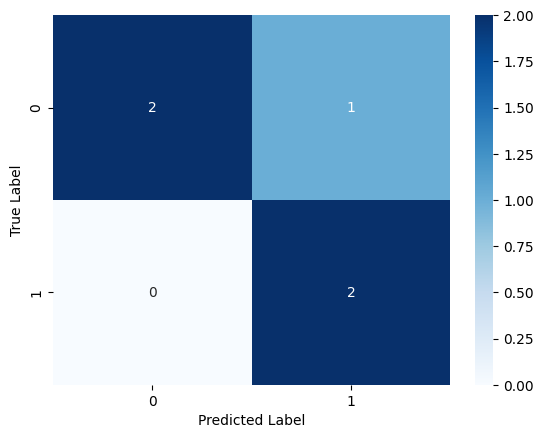

In [67]:
from sklearn.metrics import confusion_matrix

# Assuming ground_truth_labels and predicted_labels are the true and predicted labels, respectively
ground_truth_labels = [0, 1, 0, 1, 0]
predicted_labels = [0, 1, 1, 1, 0]

confusion_mat = confusion_matrix(ground_truth_labels, predicted_labels)

# Plot the heatmap
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

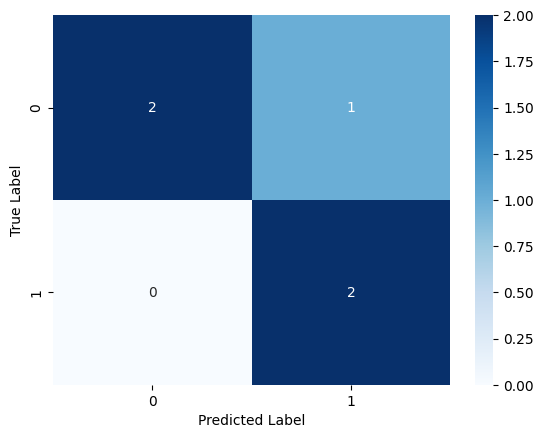

In [68]:
from sklearn.metrics import confusion_matrix

# Assuming ground_truth_labels and predicted_labels are the true and predicted labels for the first slice, respectively
ground_truth_labels = [0, 1, 0, 1, 0]  # Replace with the actual true labels
predicted_labels = [0, 1, 1, 1, 0]  # Replace with the actual predicted labels

# Calculate the confusion matrix
confusion_mat = confusion_matrix(ground_truth_labels, predicted_labels)

# Plot the heatmap
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from tensorflow.keras.models import *
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation, BatchNormalization
from tensorflow.keras.models import Model

def create_fcn_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Downsampling Path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom of the network, equivalent to the bottleneck in U-Net
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    # Upsampling Path
    up5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    conv8 = Conv2D(1, (1, 1))(conv7)
    output = Activation('sigmoid')(conv8)

    model = Model(inputs=[inputs], outputs=[output])

    return model

In [ ]:
model=create_fcn_model()
model.save('/kaggle/working/lits_fcn.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def adjustData(img, mask, flag_multi_class, num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:, :, :, 0] if(len(mask.shape) == 4) else mask[:, :, 0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i, i] = 1
        if flag_multi_class:
            new_mask = np.reshape(new_mask, (new_mask.shape[0], new_mask.shape[1] * new_mask.shape[2], new_mask.shape[3]))
        else:
            new_mask = np.reshape(new_mask, (new_mask.shape[0] * new_mask.shape[1], new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return img, mask

def trainGeneratorFCN(batch_size, train_path, image_folder, mask_folder, aug_dict,
                      image_color_mode="grayscale", mask_color_mode="grayscale",
                      image_save_prefix="image", mask_save_prefix="mask",
                      flag_multi_class=False, num_class=2, save_to_dir=None,
                      target_size=(256, 256), seed=1, subset='training'):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes=[image_folder],
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
        subset=subset)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
        subset=subset)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = adjustData(img, mask, flag_multi_class, num_class)
        yield img, mask

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    validation_split=0.2)
train_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))
valid_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,subset = 'validation',
                                target_size = (512,512))

In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

In [ ]:
show_dataset(train_generator, 3)

In [ ]:
show_dataset(valid_generator, 2)

In [ ]:
model = create_fcn_model(input_size=(512,512,1))
model.summary()

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.weights.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3,verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early]

In [1]:
num_train = 1647
num_valid = 411
train_batchsize = 16
valid_batchsize = 16
Step_train = num_train // train_batchsize
Step_valid = num_valid // valid_batchsize
epochs = 10

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=Step_train,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=Step_valid,
    verbose=1,
    callbacks=callbacks_list
)

In [ ]:
data_gen_args = dict(
                    fill_mode='nearest',
                    validation_split=0)
test_generator = trainGenerator(1,'/kaggle/input/3dircadb/3DIRCADB/test','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))

In [ ]:
show_dataset(test_generator, 2)

In [ ]:
results = model.predict(test_generator, steps=765, verbose=1)

In [ ]:
results.shape

In [ ]:
results[results >= 0.5] = 255
results[results < 0.5] = 0
results = np.asarray(results, np.uint8)

In [ ]:
plt.imshow(results[5])

In [ ]:
img = cv2.imread('../input/3dircadb/3DIRCADB/test/Images/images/image_5.png')
img = img/255
image = img[:,:,0]
image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
image_tensor = tf.expand_dims(image_tensor, 0)
mask = model.predict(image_tensor)
mask[mask >= 0.5] = 255
mask[mask < 0.5] = 0
mask = np.asarray(mask, np.uint8)
print('Prediction image and true mask:')
plt.subplot(1,2,1)
plt.imshow(mask[0])
plt.subplot(1,2,2)
true_mask = cv2.imread('../input/3dircadb/3DIRCADB/test/Masks/masks/mask_5.png')
_true_mask = true_mask[:,:,0]
plt.imshow(_true_mask)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image_tensor[0])

In [ ]:
from tensorflow.keras.models import *
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Define the input shape
input_shape = (128, 128, 3)

resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

encoder_layers = []
x = resnet_base.get_layer('conv4_block6_out').output
encoder_layers.append(x)
x = resnet_base.get_layer('conv5_block3_out').output
encoder_layers.append(x)

x = UpSampling2D(size=(2, 2))(encoder_layers[-1])
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = concatenate([x, encoder_layers[-2]], axis=3)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

model = Model(inputs=resnet_base.input, outputs=outputs)
model.save('/kaggle/working/cxr_reg_weights.best.weights.h5')

model.summary()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def unet_resnet_model(input_shape=(128, 128, 3)):
    # Load pre-trained ResNet50 model without top layers
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Encoder part
    encoder_layers = []
    x = resnet_base.get_layer('conv4_block6_out').output  # Retrieve output from a specific ResNet block
    encoder_layers.append(x)
    x = resnet_base.get_layer('conv5_block3_out').output  # Retrieve output from another ResNet block
    encoder_layers.append(x)

    # Decoder part
    x = UpSampling2D(size=(2, 2))(encoder_layers[-1])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = concatenate([x, encoder_layers[-2]], axis=3)  # Adjusted concatenation
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=resnet_base.input, outputs=outputs)

    return model

# Build the U-Net model with ResNet architecture
model = unet_resnet_model()

model.save('/kaggle/working/cxr_reg_weights.best.weights.h5')
# Display the model summary
model.summary()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def adjustData(img, mask, flag_multi_class, num_class):
    if flag_multi_class:
        img = img / 255.
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return img, mask
    else:
        img = img / 255.
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return img, mask

def trainGenerator(batch_size, train_path, image_folder, mask_folder,
                   aug_dict, image_color_mode="grayscale",
                   mask_color_mode="grayscale", image_save_prefix="image",
                   mask_save_prefix="mask", flag_multi_class=False,
                   num_class=2, save_to_dir=None, target_size=(256, 256),
                   seed=1, subset='training'):
    '''
    Generate image and mask pairs for SegNet model training.
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes=[image_folder],
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
        subset=subset
    )

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
        subset=subset
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjustData(img, mask, flag_multi_class, num_class)
        yield (img, mask)

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    validation_split=0.2)
train_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))
valid_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,subset = 'validation',
                                target_size = (512,512))

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')  # Corrected colormap
    plt.show()

In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

In [ ]:
show_dataset(train_generator,3)

In [ ]:
show_dataset(valid_generator,2)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path = "{}_weights.best.weights.h5".format('cxr_reg')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [ ]:
num_train = 1647
num_valid = 411
train_batchsize = 16
valid_batchsize = 16
Step_train = num_train // train_batchsize
Step_valid = num_valid // valid_batchsize
epochs = 10

In [ ]:
def unet(input_size=(512,512,3)):
    inputs = Input(input_size)
train_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))
valid_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,subset = 'validation',
                                target_size = (512,512))

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def unet_resnet_model(input_shape=(128, 128, 3)):
    # Load pre-trained ResNet50 model without top layers
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Encoder part
    encoder_layers = []
    x = resnet_base.get_layer('conv4_block6_out').output  # Retrieve output from a specific ResNet block
    encoder_layers.append(x)
    x = resnet_base.get_layer('conv5_block3_out').output  # Retrieve output from another ResNet block
    encoder_layers.append(x)

    # Decoder part
    x = UpSampling2D(size=(2, 2))(encoder_layers[-1])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = concatenate([x, encoder_layers[-2]], axis=3)  # Adjusted concatenation
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    outputs = Flatten()(outputs)  # Flatten the output to match the shape of target labels

    # Create the model
    model = Model(inputs=resnet_base.input, outputs=outputs)

    return model

# Build the U-Net model with ResNet architecture
model = unet_resnet_model()

# Compile the model with appropriate loss function and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def adjustData(img, mask, flag_multi_class, num_class):
    if flag_multi_class:
        img = img / 255.
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return img, mask
    else:
        img = img / 255.
        mask = mask / 255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return img, mask

def trainGenerator(batch_size, train_path, image_folder, mask_folder,
                   aug_dict, image_color_mode="grayscale",
                   mask_color_mode="grayscale", image_save_prefix="image",
                   mask_save_prefix="mask", flag_multi_class=False,
                   num_class=2, save_to_dir=None, target_size=(256, 256),
                   seed=1, subset='training'):
    '''
    Generate image and mask pairs for SegNet model training.
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes=[image_folder],
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
        subset=subset
    )

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
        subset=subset
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjustData(img, mask, flag_multi_class, num_class)
        yield (img, mask)

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    validation_split=0.2)
train_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,
                                target_size = (512,512))
valid_generator = trainGenerator(16,'../input/3dircadb/3DIRCADB/train','Images','Masks',data_gen_args,save_to_dir = None,subset = 'validation',
                                target_size = (512,512))

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')  # Corrected colormap
    plt.show()

In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

In [ ]:
show_dataset(train_generator,2)

In [ ]:
show_dataset(valid_generator,2)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="/kaggle/input/dataset/cxr_reg_weights.best.weights.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [ ]:
num_train = 1647
num_valid = 411
train_batchsize = 16
valid_batchsize = 16
Step_train = num_train // train_batchsize
Step_valid = num_valid // valid_batchsize
epochs = 10

In [ ]:
from keras.layers import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

input_layer = Input(shape=(512, 512, 3))
x = Conv2D(16, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(2, activation='linear')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)